# Demo of waveform data loading options for gw_eccentricity
 For package details, see https://pypi.org/project/gw_eccentricity.

In [1]:
from gw_eccentricity import load_waveform, load_data
from gw_eccentricity.load_data import get_available_waveform_origins, get_load_waveform_defaults, get_load_waveform_docs
import matplotlib.pyplot as plt
from gw_eccentricity.plot_settings import use_fancy_plotsettings, labelsDict # for better looking plots
import numpy as np
%load_ext autoreload
%autoreload 2

# Read the documentation

The function `load_waveform` can be used to load waveform data into a dictionary format suitable for `gw_eccentricity` (see `gw_eccentricity_demo.ipynb`)

In [2]:
help(load_waveform)

Help on function load_waveform in module gw_eccentricity.load_data:

load_waveform(origin='LAL', **kwargs)
    Load waveform.
    
    Parameters
    ----------
    origin: str
        The origin of the waveform to be generated/loaded. This can be one of
    
        - "LAL": Compute waveform by a call to the LAL-library.
            (see https://lscsoft.docs.ligo.org/lalsuite/lalsimulation/)
        - "SXSCatalog": Import waveform by reading a file in the SXS catalog
            in the new format (from 2023 onward) where the waveform files are
            named as `Strain_N{extrap_order}.h5` for a given extrapolation
            order `extrap_order`.
            (see https://data.black-holes.org/waveforms/documentation.html)
        - "SXSCatalog_old": Import waveform by reading a file in the SXS
            catalog in the old format (prior to 2023) where the waveform file
            is named as `rhOverM_Asymptotic_GeometricUnits_CoM.h5`.
            (see https://data.black-holes.org

# Available waveform `origin`s
`load_waveform` can load waveforms of different "origins" like the SXS NR Catalog or the LIGO Algorithm Library (`LAL`). Available`origin`s can be obtained using `get_available_waveform_origins()`

In [3]:
get_available_waveform_origins()

['LAL', 'SXSCatalog', 'SXSCatalog_old', 'LVCNR', 'LVCNR_hack', 'EOB', 'EMRI']

## Load waveform data using `LAL`

To generate waveform using models in `LALSuite` call `load_waveform` with `origin="LAL"` and relevant `kwargs`.<br>
The allowed kwargs and defaults values can be obtained using `get_load_waveform_defaults("LAL")`

In [4]:
get_load_waveform_defaults("LAL")

{'approximant': None,
 'q': None,
 'chi1': None,
 'chi2': None,
 'ecc': None,
 'mean_ano': None,
 'Momega0': None,
 'deltaTOverM': 0.1,
 'physicalUnits': False,
 'M': None,
 'D': None,
 'include_zero_ecc': False}

In [5]:
# Uncomment below and run to get details of allowed kwargs for origin='LAL'
# get_load_waveform_docs("LAL")

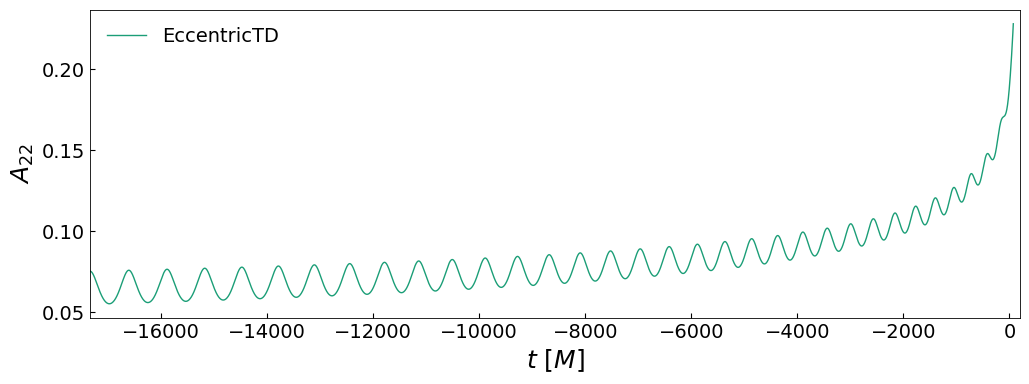

In [6]:
# As of Feb 2023, the only time-domain eccentric model available through LAL is EccentricTD,
# which does not include the merger, and is restricted to nonspinning BHs.
# We expect that more eccentric models will be added in the future.
# Note that EccentricTD only allows ecc > 1e-5, and ignores the mean_ano parameter.
kwargs = {
    "approximant": "EccentricTD",
    "q": 2.0,
    "ecc": 0.1,
    "chi1": [0.0, 0.0, 0.0],
    "chi2": [0.0, 0.0, 0.0],
    "mean_ano": 0.0,
    "Momega0": 0.01,
}
origin = "LAL"
dataDict = load_waveform(origin, **kwargs)
use_fancy_plotsettings(usetex=False)
fig, ax = plt.subplots(figsize=(12, 4))
# Plot the amplitude of the (2,2) mode
ax.plot(dataDict["t"], np.abs(dataDict["hlm"][(2, 2)]), label=kwargs["approximant"])
ax.set_xlim(dataDict["t"][0], 200)
ax.set_xlabel(labelsDict["t_dimless"])
ax.set_ylabel(labelsDict["amp22"])
ax.legend(loc="upper left")

## Load waveform data from SXS catalog format file
Waveform data from a file in [SXS catalog format](https://data.black-holes.org/waveforms/documentation.html) can be loaded using `origin="SXSCatalog"` and providing necessary `kwargs`.

The allowed `kwargs` and their default values can be obtained using `get_load_waveform_defaults("SXSCatalog")`

In [7]:
origin = "SXSCatalog"
get_load_waveform_defaults(origin)

{'data_dir': None,
 'metadata_path': None,
 'deltaTOverM': 0.1,
 'include_zero_ecc': False,
 'include_params_dict': False,
 'zero_ecc_approximant': 'IMRPhenomT',
 'num_orbits_to_remove_as_junk': 2,
 'mode_array': [(2, 2)],
 'extrap_order': 2}

**NOTE:** Since 2023, the SXS catalog uses a new format for the waveform files where each file corresponds to a specific extrapolation order, whereas in the old format a single waveform file contains all the extrapolated waveforms. The user should use the `load_waveform` function with `origin='SXSCatalog'` for this new format and `origin='SXSCatalog_old'` for the old format. The only difference in these two cases is the waveform files that should exist in the `data_dir`. For `SXSCatalog`, the `data_dir` should contain `Strain_N{extrap_order}.h5` and `Strain_N{extrap_order}.json` file. For `SXSCatalog_old`, the `data_dir` should contain `rhOverM_Asymptotic_GeometricUnits_CoM.h5` file.

### What files should exist in `data_dir`
The `load_waveform` function looks for the following files in `data_dir` when `origin` is `SXSCatalog` or `SXSCatalog_old`

Here's an improved version of the documentation:

- **Waveform Files:** These files, as explained earlier, are **required** for loading waveform modes.

- **`metadata.txt` File:** This file contains metadata related to the binary parameters used in the NR simulation. It is required when either `include_zero_ecc` or `include_params_duct` is set to True.

- **`Horizons.h5` File:** This file holds the dynamical variables for the simulation. It's an **optional** file. When provided, it is used to estimate the orbit duration for removing junk radiation based on `num_orbits_to_remove_as_junk`. If not provided, the phase of the (2, 2) mode is used for the same purpose. However, since the (2, 2) mode's phase is affected by the junk radiation itself, the estimated orbit duration may not be highly accurate.

In [8]:
# Uncomment below and run to get details of allowed kwargs for origin='SXSCatalog'
# get_load_waveform_docs("SXSCatalog")

Text(0, 0.5, '$A_{22}$')

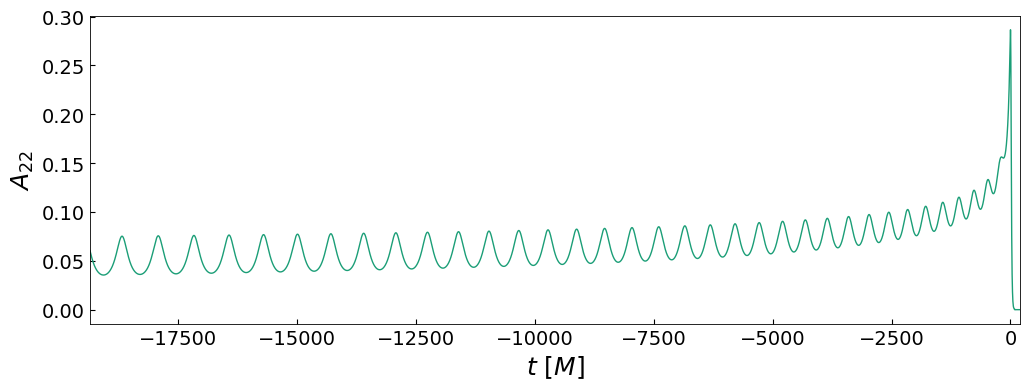

In [9]:
# Load nr data from sxs catalog format file
kwargs = {"data_dir": "data/SXS:BBH:2538/Lev3/"}
dataDict = load_waveform(origin="SXSCatalog", **kwargs)


fig, ax = plt.subplots(figsize=(12, 4))
# Plot the amplitude of the (2,2) mode
ax.plot(dataDict["t"], np.abs(dataDict["hlm"][(2, 2)]))
ax.set_xlim(dataDict["t"][0], 200)
ax.set_xlabel(labelsDict["t_dimless"])
ax.set_ylabel(labelsDict["amp22"])

### Load a sxs catalog format file in the old format

Text(0, 0.5, '$A_{22}$')

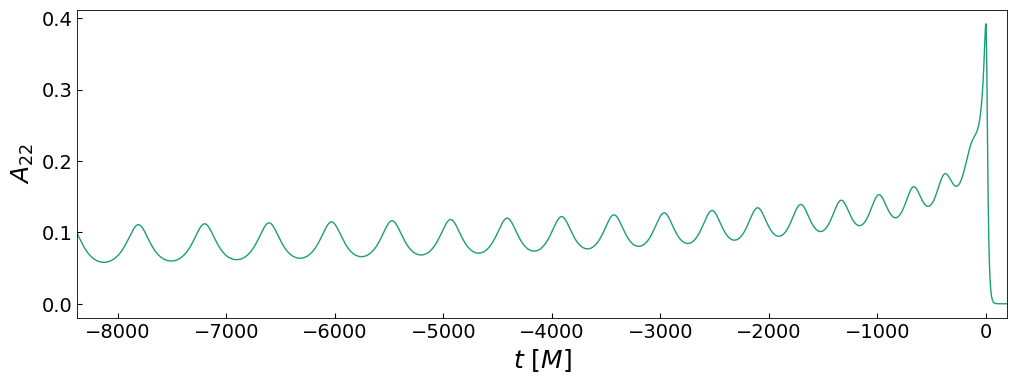

In [10]:
kwargs = {"data_dir": "data/SXS:BBH:2311/Lev3/"}
dataDict = load_waveform(origin="SXSCatalog_old", **kwargs)


fig, ax = plt.subplots(figsize=(12, 4))
# Plot the amplitude of the (2,2) mode
ax.plot(dataDict["t"], np.abs(dataDict["hlm"][(2, 2)]))
ax.set_xlim(dataDict["t"][0], 200)
ax.set_xlabel(labelsDict["t_dimless"])
ax.set_ylabel(labelsDict["amp22"])

### Load quasicircular counterpart for SXSCatalog format
For measuring eccentricity using residual methods like `ResidualAmplitude`, we need to include the quasicircular counterpart also in the `dataDict`. This can be done by setting `include_zero_ecc` to `True`,
and providing the path to the simulation metadata (`metadata_path`; look for `metadata.txt` that comes alongside `rhOverM_Asymptotic_GeometricUnits_CoM.h5`), so that the correct parameters for generating the quasicircular counterpart can be used.

One can also choose what waveform model to use for generating quasicircular waveform via `zero_ecc_approximant`. The default is `IMRPhenomT`.

**NOTE:** `SEOBNRv4ROM_v2.0.hdf5` is required in `LAL_DATA_PATH` to get an estimate for the initial
frequency for generating the quasicircular waveform. Download it from https://git.ligo.org/lscsoft/lalsuite-extra/-/blob/master/data/lalsimulation/SEOBNRv4ROM_v2.0.hdf5
and set the path using
```bash
export LAL_DATA_PATH=/path/to/directory/containing/seobnrv4rom_file/
```

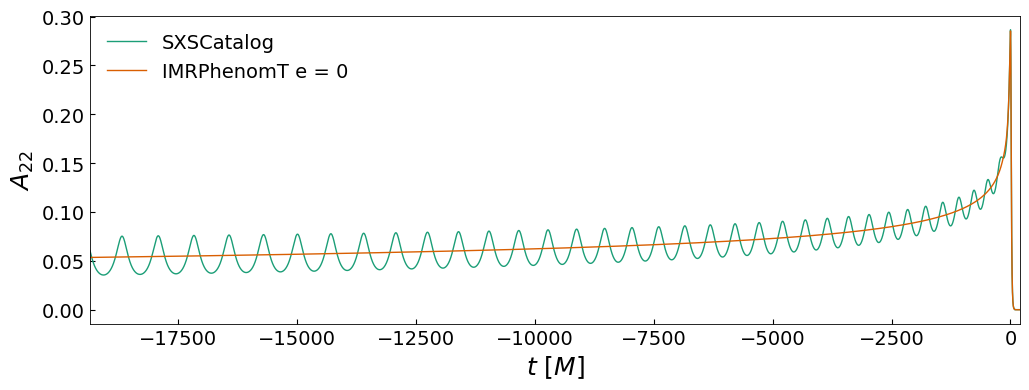

In [11]:
kwargs = {"data_dir": "data/SXS:BBH:2538/Lev3/",
         "include_zero_ecc": True,
         "zero_ecc_approximant": "IMRPhenomT"}
dataDict = load_waveform(origin, **kwargs)

# use better defaults for plotting
use_fancy_plotsettings(usetex=False)
fig, ax = plt.subplots(figsize=(12, 4))
# plot amplitude of the (2, 2) mode of eccentric waveform
ax.plot(dataDict["t"], np.abs(dataDict["hlm"][(2, 2)]), label=origin)
# plot amplitude of the (2, 2) mode of zeroecc waveform
ax.plot(dataDict["t_zeroecc"], np.abs(dataDict["hlm_zeroecc"][(2, 2)]), label=kwargs["zero_ecc_approximant"] + " e = 0")
ax.set_xlim(dataDict["t"][0], 200)
ax.set_xlabel(labelsDict["t_dimless"])
ax.set_ylabel(labelsDict["amp22"])
ax.legend(loc="upper left")

## Load waveform data from `LVCNR` format file
Waveform data from a file in `LVCNR` format can be loaded using `origin="LVCNR"` and providing necessary `kwargs`.

The allowed `kwargs` and defaults can be obtained using `get_load_waveform_defaults("LVCNR")`

In [12]:
origin = "LVCNR"
get_load_waveform_defaults(origin)

{'filepath': None,
 'deltaTOverM': 0.1,
 'Momega0': 0.0,
 'include_zero_ecc': False,
 'include_params_dict': False,
 'zero_ecc_approximant': 'IMRPhenomT',
 'num_orbits_to_remove_as_junk': 2}

In [13]:
# Uncomment below and run to get details of allowed kwargs for origin='LVCNR'
# get_load_waveform_docs("LVCNR")

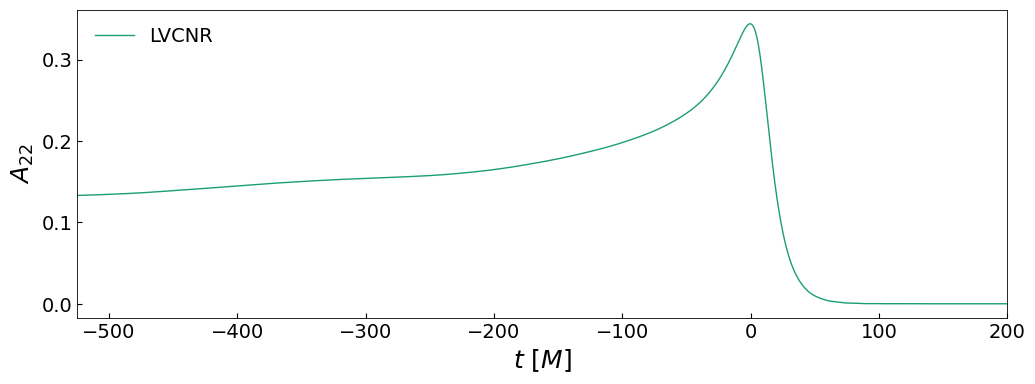

In [14]:
# Load nr data from LVCNR format file using only filepath and using defaults for other kwargs
kwargs = {"filepath": "data/RIT/ExtrapStrain_RIT-BBH-0078-n100.h5"}
dataDict = load_waveform(origin=origin, **kwargs)

fig, ax = plt.subplots(figsize=(12, 4))
# plot amplitude of the (2, 2) mode
ax.plot(dataDict["t"], np.abs(dataDict["hlm"][(2, 2)]), label=origin)
ax.set_xlim(dataDict["t"][0], 200)
ax.set_xlabel(labelsDict["t_dimless"])
ax.set_ylabel(labelsDict["amp22"])
ax.legend(loc="upper left")